# Chandra data for TYC 2597 735 1
In this notebook, I'm analysing the Chandra data for TYC 2597 735 1.
Before starting this notebook, I downloaded the data and run `chandra_repro 8636`. Once that is done, this notebook should just run by itself to reproduce my analysis exactly.

In [1]:
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sherpa.astro.ui as ui
from astropy.table import Table, QTable
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as c
import astropy.visualization as avis
from scipy.ndimage.filters import gaussian_filter
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle

from ciao_contrib import runtool as rt
from ciao_contrib.cda.data import download_chandra_obsids

%matplotlib inline

In [2]:
# Set better defaults for log plots with a small (< 2 mag) range
mpl.rcParams['axes.formatter.min_exponent'] = 2

In [3]:
download_chandra_obsids([8636])

[True]

In [173]:
rt.chandra_repro(indir= "8636", check_vf_pha=True, clobber=True)


Running chandra_repro
version: 14 September 2021


Processing input directory '/Users/guenther/projects/Chandraprojects/Keri/8636'

No boresight correction update to asol file is needed.
Resetting afterglow status bits in evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: /Users/guenther/projects/Chandraprojects/Keri/8636/repro/acisf08636_repro_evt2.fits

Updating the event file header with chandra_repro HISTORY record
Creating FOV file...
Setting observation-specific bad pixel file in local ardlib.par.

Cleaning up intermediate files

         /Users/guenther/projects/Chandraprojects/Keri/8636/repro/acisf08636_repro_bpix1.fits
         Run 'punlearn ardlib' when analysis of this dataset completed.

The data have been reproce

In [174]:
fileevt2 = glob('8636/repro/*evt2*')[0]
asol = glob('8636/repro/pcad*asol*')[0]
bpix = glob('8636/repro/*bpix*')[0]

### Source detection

We know the location of the central source, thus we can extract is without even detecting it. In Poisson statistics, detecting sources blind with no pripor knowledge requires more counts than learning something from a weak source at a know location. Also, the source is located so close to the corners of the chip that some source detection algorithms will have trouble finding it.

However, I'll run `wavdetect` to find any additional sources in the image. I've looked at the image in ds9, so this is an algorihtmic confirmation that what I see is really there, but a fully independent source detection. In particular, I will choose an energy band to study. Without energy filtering we will not find the weak sources we are interested in, there is simpy so much background over the entire Chandra band that they are not significant. However, we do have some knowledge and can restrict ourselves to moderately absorbed sources (because they are almost 2 kpc away), so we'll pick 1 keV as the lower boundary. We also don't see them to be super-hard sources when looking at image. For a thermal source, say a shock or coronal emission, the peak is in the 1-2 keV range, so we'll pick 2 keV as the upper limit. Thus, our bandpass is only 1 keV wide, which reduces the background by an order of magnitude compared to the full Chandra band.

In [194]:
# Restrict to lower half of the S2 chip which is the region we care for
rt.dmcopy(infile=f"{fileevt2}[ccd_id=6, energy=500:3000][bin x=2500:3600:5,y=5150:5850:5]", 
          outfile='8636/ccd6_narrowband.fits', clobber=True, option='image')
rt.mkpsfmap(infile='8636/ccd6_narrowband.fits', outfile='ccd6_narrowband_psfmap.fits',
            energy=1.5, ecf=0.393, clobber=True)
rt.mkpsfmap(infile='8636/ccd6_narrowband.fits', outfile='ccd6_narrowband_psfmap_90.fits',
            energy=1.5, ecf=0.9, clobber=True, units='arcsec')

In [195]:
rt.wavdetect.punlearn()
rt.wavdetect(infile='8636/ccd6_narrowband.fits', psffile='ccd6_narrowband_psfmap.fits',
             outfile='ccd6_src.fits', scellfile='ccd6_scell.fits', imagefile='ccd6_imgfile.fits',
             defnbkgfile='ccd6_nbgd.fits', regfile='ccd6_src.reg', clobber=True,
             scales='2 4 8 16', sigthresh=1e-5
            )


In [196]:
tabwavdetect = Table.read('ccd6_src.fits')

In [210]:
for col in ['RA_ERR', 'DEC_ERR']:
    tabwavdetect[col] = tabwavdetect[col].to(u.arcsec)
    tabwavdetect[col].format='{:4.1f}'
tabwavdetect['name'] = ['TYC 2597-735-1', 'X-East', 'X-North']
#tabwavdetect['name'] = np.arange(len(tabwavdetect))
for col in ['NET_COUNTS', 'NET_COUNTS_ERR']:
    tabwavdetect[col].format = '{:4.1f}'
for col in ['BKG_COUNTS', 'BKG_COUNTS_ERR']:
    tabwavdetect[col].format = '{:4.2f}'


`srcflux` can be called with a list of source positions, but instead of constructing an input file with the correct syntax, we just call the tool several times and then read in several output files.

In [407]:
for row in tabwavdetect:
    rt.srcflux(infile=fileevt2, 
               pos=f"{Angle(row['RA'] * u.deg).to_string(unit=u.hourangle, sep=':')} {Angle(row['DEC'] * u.deg).to_string(unit=u.deg, sep=':', alwayssign=True)}",
               outroot=row['name'].replace(' ', '_'),
               band='.5:3:2',
               srcreg=f"circle({row['X']},{row['Y']},{row['psf_size']/60}')",
               bkgreg="circle(16:48:50.6491,+35:16:57.372,2.0')",
               psfmethod='arfcorr',
               clobber=True,
              )

In [412]:
tabwavdetect.remove_columns(['NET_COUNTS_APER', 'NET_COUNTS_APER_LO', 'NET_COUNTS_APER_HI'])

In [413]:
copycols = ['NET_RATE_APER', 'NET_RATE_APER_LO', 'NET_RATE_APER_HI']
for col in copycols:
    tabwavdetect[col] = 0
    tabwavdetect[col].unit = u.count
for i, row in enumerate(tabwavdetect):
    tab = Table.read(f"{row['name'].replace(' ','_')}_.5-3.flux", format='fits', hdu=1)
    for c in copycols:
        tabwavdetect[c][i] = tab[c][0] * evt.meta['LIVTIME2']
        
tabwavdetect.rename_column('NET_RATE_APER','NET_COUNTS_APER')
tabwavdetect.rename_column('NET_RATE_APER_LO','NET_COUNTS_APER_LO')
tabwavdetect.rename_column('NET_RATE_APER_HI','NET_COUNTS_APER_HI')

In [414]:
tabwavdetect

RA,DEC,RA_ERR,DEC_ERR,X,Y,X_ERR,Y_ERR,NPIXSOU,NET_COUNTS,NET_COUNTS_ERR,BKG_COUNTS,BKG_COUNTS_ERR,NET_RATE,NET_RATE_ERR,BKG_RATE,BKG_RATE_ERR,EXPTIME,EXPTIME_ERR,SRC_SIGNIFICANCE,PSF_SIZE,MULTI_CORREL_MAX,SHAPE,R [2],ROTANG,PSFRATIO,COMPONENT,X_CORRELATION_MAX,Y_CORRELATION_MAX,X_FLUX_MAX,Y_FLUX_MAX,X_WAVELET_SCALE,Y_WAVELET_SCALE,name,psf_size,NET_COUNTS_APER_LO,NET_COUNTS_APER_HI,NET_COUNTS_APER
deg,deg,arcsec,arcsec,pix,pix,pix,pix,pix,ct,ct,ct,ct,,,,,,,,pix,,,pix,deg,,,pix,pix,pix,pix,pix,pix,,,ct,ct,ct
float64,float64,float64,float64,float64,float64,float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes10,float32,float32,float32,int32,float64,float64,float64,float64,float32,float32,str14,float32,int64,int64,int64
252.15585475230458,35.203340659963075,2.9,2.0,3232.857142857143,5312.142857142857,4.882922283751213,4.148527084150373,226,10.6,3.7,3.37,0.02,10.63139,3.741718,3.3686104,0.02130872,1.0,0.0,3.5093627,15.15354,0,ellipse,56.260494 .. 44.804695,158.1026,1.1044046,1,3232.5,5307.5,3222.5,5312.5,4.0,4.0,TYC 2597-735-1,17.040705,3,17,9
252.21217622708974,35.20473831687335,2.7,1.8,2896.1363636363635,5322.954545454545,4.411241700854134,3.605238696064589,405,17.5,5.0,7.54,0.03,17.455662,5.0001025,7.544338,0.03204798,1.0,0.0,4.498894,19.769495,0,ellipse,44.417244 .. 35.21834,165.4162,0.66687346,2,2907.5,5332.5,2917.5,5332.5,4.0,4.0,X-East,22.289568,7,23,14
252.14800757493012,35.25703953799028,2.2,2.3,3280.3125,5705.0,3.61660531221969,4.571480886977042,220,11.1,4.0,4.91,0.03,11.089561,4.00009,4.910438,0.026880594,1.0,0.0,3.2817438,21.362963,0,ellipse,58.286976 .. 38.671688,63.148983,0.74079764,3,3287.5,5697.5,3287.5,5712.5,4.0,4.0,X-North,24.485075,5,22,13


In [422]:
# Make cope before reformatting some columns to string
srctab = QTable(tabwavdetect['name', 'RA', 'DEC', 'RA_ERR', 'DEC_ERR', 'NET_COUNTS_APER'
                             ],
                copy=True)

for col in ['NET_COUNTS_APER']:
    srctab[col].format = '{:d}'
srctab['RA'] = Angle(tabwavdetect['RA']).to_string(unit=u.hourangle, format='latex', precision=0)
srctab['DEC'] = Angle(tabwavdetect['DEC']).to_string(unit=u.deg, format='latex',precision=0)
import sys

srctab.rename_column('NET_COUNTS_APER','net counts')
srctab['90\% credible interval'] = [f"{row['NET_COUNTS_APER_LO']:d}-{row['NET_COUNTS_APER_HI']:d}" for row in tabwavdetect]

for col in srctab.colnames:
    newname = col.replace('_', ' ')
    srctab.rename_column(col, newname)
    if 'ERR' in col:
        srctab.rename_column(newname, f'$\\sigma_\\mathrm[{newname[:-4]}]$'.replace('[', '{').replace(']', '}'))

        
srctab.write(sys.stdout, format='ascii.latex', caption=r'Detected X-ray sources in the 0.5-3.0~keV band\label{tab:src}',
             latexdict=ascii.latexdicts['AA'])

\begin{table}
\caption{Detected X-ray sources in the 0.5-3.0~keV band\label{tab:src}}
\begin{tabular}{ccccccc}
\hline \hline
name & RA & DEC & $\sigma_\mathrm{RA}$ & $\sigma_\mathrm{DEC}$ & net counts & 90\% credible interval \\
 &  &  & $\mathrm{{}^{\prime\prime}}$ & $\mathrm{{}^{\prime\prime}}$ & $\mathrm{ct}$ &  \\
\hline
TYC 2597-735-1 & $16^{\mathrm{h}}48^{\mathrm{m}}37^{\mathrm{s}}$ & $35^\circ12{}^\prime12{}^{\prime\prime}$ & 2.9 & 2.0 & 9.0 & 3-17 \\
X-East & $16^{\mathrm{h}}48^{\mathrm{m}}51^{\mathrm{s}}$ & $35^\circ12{}^\prime17{}^{\prime\prime}$ & 2.7 & 1.8 & 14.0 & 7-23 \\
X-North & $16^{\mathrm{h}}48^{\mathrm{m}}36^{\mathrm{s}}$ & $35^\circ15{}^\prime25{}^{\prime\prime}$ & 2.2 & 2.3 & 13.0 & 5-22 \\
\hline
\end{tabular}
\end{table}


What's the chance of a chance alignment?

In [213]:
# Number of pixels in the image used for wavdetect
n_pix = (1100 / 5) * (700 / 5)
# Not all pixels are actually exposed. How much of the area is within the FOV?
# About 15% - estimated fomr looking at the binned image in ds9
print(n_pix * 0.85)

26180.0


In [214]:
1/((0.145 * u.degree * 0.08 * u.degree) / (0.28 * u.arcmin)**2).decompose()

<Quantity 0.00187739>

And, voila, `wavdetect` found the source just south of the strong Ha emission with 2.3 sigma significance. Not groundbreaking, but the paramters are set to only detect 1 false source for an input image with 1e6 pixels and the input image we use only has 30800 pixels - this source is real (but weak - only 6 net counts in this energy range). 

### Extract spectra

In [215]:
psfmap = fits.open('ccd6_narrowband_psfmap_90.fits')
wcspsfmap = WCS(psfmap[0].header)

Set MJD-END to 54430.708530 from DATE-END'. [astropy.wcs.wcs]


In [216]:
index = wcspsfmap.world_to_pixel(SkyCoord(tabwavdetect['RA'], tabwavdetect['DEC']))
index = np.asarray(np.floor(index), dtype=np.int)

In [217]:
tabwavdetect['psf_size'] = psfmap[0].data[index[1, :], index[0, :]]

In [218]:
rt.ardlib.punlearn()
# set badpixel files for all CCDs that are used in the observation
for i in ['0', '1', '2', '3', '6']:
    setattr(rt.ardlib, f'AXAF_ACIS{i}_BADPIX_FILE', f"{bpix}[BADPIX{i}]")
rt.ardlib.write_params()

In [219]:
psfmap.info()

Filename: ccd6_narrowband_psfmap_90.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     945   (220, 140)   float32   
  1  GTI           6 BinTableHDU     26   2R x 2C   [1D, 1D]   


In [453]:
binsize = [0.1, 0.1, 1]

for row in tabwavdetect:
    print(f'working on {row["name"]}')
    rt.specextract.punlearn()
    print(f"{fileevt2}[sky=circle({row['X']},{row['Y']},{row['psf_size']/60}')]")
    rt.specextract(infile=f"{fileevt2}[sky=circle({row['X']},{row['Y']},{row['psf_size']/60}')]",
               #outroot='weight_' + row['name'].replace(' ','_'), 
                   outroot=row['name'].replace(' ','_'), 
               bkgfile=f"{fileevt2}[sky=circle(16:48:50.6491,+35:16:57.372,2.0')]", 
               grouptype="NONE", binspec="NONE", weight=False, correctpsf=True, clobber=True,
                   binarfcorr=binsize[i], refcoord=f"{row['RA']} {row['DEC']}"
    )

working on TYC 2597-735-1
8636/repro/acisf08636_repro_evt2.fits[sky=circle(3232.857142857143,5312.142857142857,0.2840117454528809')]
working on X-East
8636/repro/acisf08636_repro_evt2.fits[sky=circle(2896.1363636363635,5322.954545454545,0.37149279912312827')]
working on X-North
8636/repro/acisf08636_repro_evt2.fits[sky=circle(3280.3125,5705.0,0.4080845832824707')]


In [221]:
# make instrument map and exposure map
for i in ['0', '1', '2', '3', '6']:
    rt.asphist(infile=asol, outfile=f'8636/asphist_{i}.fits', evtfile=f"{fileevt2}[ccd_id={i}]", clobber=True)
    rt.mkinstmap(outfile=f"8636/acis_{i}_instmap.fits", monoenergy=1.5, 
             pixelgrid="1:1024:#1024,1:1024:#1024", obsfile=f"{fileevt2}[EVENTS]",
             dafile=None, detsubsys=f"ACIS-{i}", clobber=True)
    rt.mkexpmap(asphistfile=f'8636/asphist_{i}.fits', outfile=f'8636/expmap_{i}.fits',
            instmapfile=f"8636/acis_{i}_instmap.fits", xygrid="2300:5500:#1024,2500:6500.0:#1024",
            clobber=True)

I could have plotted the resuting exposure maps here, but I found it faster to just open them in ds9. Python is great, but in ds9 it's just so easy to do an interactive analysis. Why do I do this at all? I noticed that our source is pretty close to the edge of the chip. Since Chandra dithers, there are not sharp chip edges, but regions close to the corner dither on an off the chip, effectively giving us a shorter exposure time. That's not a problem for spectral fitting (CIAO calculates this effect when making the ARF), but when we write text like "We saw XX photons in YY ks",  then we should use the actual time. However, I found that we are still far away enough from the chip edge that our source is on the chip for the entire observation.

## Make an image

In [222]:
hahdus = fits.open('BRN_Ha_final.fits')
hawcs = WCS(hahdus[0].header)
uvhdus = fits.open('BRN-fd-int.fits')
uvwcs = WCS(uvhdus[0].header)

instmaphdus = fits.open('8636/acis_2_instmap.fits')
instmapwcs = WCS(instmaphdus[0].header)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 54430.708530 from DATE-END'. [astropy.wcs.wcs]


### Determine the level we will use for FUV contour
Select a regions that is background only (and a few bright stars obviously) and look at the mean values and the spread in terms of FWHM. FWHM is easy to read off by hand can can then be converted to sigma by deviding by 2.35. 

In [223]:
uvhdus.info()

Filename: BRN-fd-int.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     511   (1280, 1280)   float32   


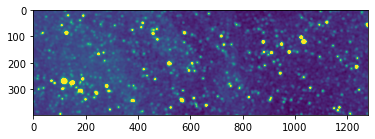

In [224]:
plt.imshow(gaussian_filter(uvhdus[0].data, 3.)[0:400], vmax=0.0006)

(0.00025, 0.0004)

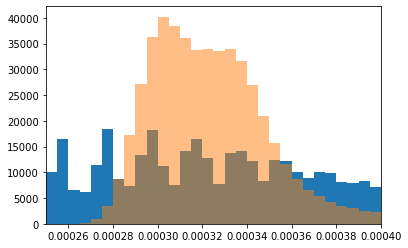

In [225]:
out = plt.hist(uvhdus[0].data[0:400].flatten(), bins=np.arange(0, 10e-4, 5e-6), label='original image')
out2 = plt.hist(gaussian_filter(uvhdus[0].data, 3.)[0:400].flatten(), 
                bins=np.arange(0, 10e-4, 5e-6), alpha=.5, label='smoothed image')

plt.xlim(0.00025, 0.0004)

In [226]:
0.0003 / (0.00006 / 2.35)

11.749999999999998

In [227]:
hdus = fits.open('8636/repro/acisf08636_repro_evt2.fits')
head = hdus[1].header
evt = Table.read('8636/repro/acisf08636_repro_evt2.fits', hdu='EVENTS')

In [228]:
tw = WCS(fits.getheader('clean.fits', 'EVENTS'), keysel=['pixel'], naxis=['celestial'])

image-header keyword MJD-OBS in binary table. [astropy.wcs.wcs]
image-header keyword DATE-OBS in binary table. [astropy.wcs.wcs]
image-header keyword DATE-END in binary table. [astropy.wcs.wcs]
image-header keyword TIMESYS in binary table. [astropy.wcs.wcs]
image-header keyword MJDREF in binary table. [astropy.wcs.wcs]
image-header keyword TIMEUNIT in binary table. [astropy.wcs.wcs]
image-header keyword TSTART in binary table. [astropy.wcs.wcs]
image-header keyword TSTOP in binary table. [astropy.wcs.wcs]
image-header keyword TIMEPIXR in binary table. [astropy.wcs.wcs]
image-header keyword RADESYSa in binary table. [astropy.wcs.wcs]
image-header keyword TIMEDEL in binary table. [astropy.wcs.wcs]


In [229]:
from astropy.coordinates import SkyCoord
TYC_coord = SkyCoord.from_name('TYC 2597-735 1')

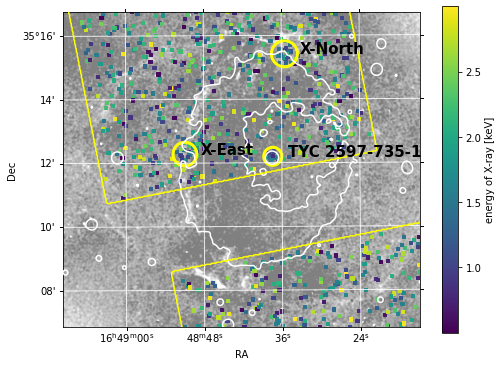

In [230]:
#hainterval = avis.ZScaleInterval()
#hanorm = avis.ImageNormalize(hahdus[0].data, interval=avis.ZScaleInterval())  #stretch=
soft = evt[(evt['energy'] > 500) & (evt['energy'] < 3000)]

fig = plt.figure(figsize=(8, 6)) # large image is easier in browser. Adjust for publication
ax = fig.add_subplot(projection=hawcs)
im = ax.imshow(hahdus[0].data, vmin=-214, vmax=-207, cmap=plt.get_cmap('Greys_r'), alpha=.5) #, norm=hanorm)
ax.contour(gaussian_filter(uvhdus[0].data, 3.), transform=ax.get_transform(uvwcs),
           levels=[0.0006], colors='white')
for i in ['2', '3', '6']:
    expmaphdus = fits.open(f'8636/expmap_{i}.fits')
    expmapwcs = WCS(expmaphdus[0].header)
    ax.contour(expmaphdus[0].data, transform=ax.get_transform(expmapwcs),
               levels=[1], colors='yellow')
scat = ax.scatter(soft['x'], soft['y'], c=soft['energy'] / 1000, marker='s', s=10, transform=ax.get_transform(tw))

for row in tabwavdetect:
    r = avis.wcsaxes.SphericalCircle((row['RA'] * u.degree, row['DEC'] * u.degree),
                                     row['psf_size'] * u.arcsec,
                     edgecolor='yellow', facecolor='none',lw=3,
                     transform=ax.get_transform('fk5'))
    ax.add_patch(r)
    ax.text(row['RA'] - 0.01, row['DEC'],
            row['name'], transform=ax.get_transform('fk5'), fontweight=800,
            fontsize=15, color='k')

ax.grid(color='white')

ax.set_xlim(10, hahdus[0].data.shape[1] - 10)
ax.set_ylim(10, hahdus[0].data.shape[0] - 10)
ax.invert_yaxis()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

cbar = fig.colorbar(scat)
cbar.set_label('energy of X-ray [keV]')
fig.savefig('/Users/guenther/MITDropbox/my_articles/KeriTYC/figures/chandraimage.pdf', bbox_inches='tight')

## Time dependence
Is the emission from TYC due to a short flare? THe plot below shows the timeing of the energy-filtered, soft photons and it seem pretty randomly distributed. Some clmumping is normal in Poisson statistics and  I don't see anything beyond that but, obviously, that's not a very strong statement given the low number of photons.

Text(0.5, 0, 'Time [s]')

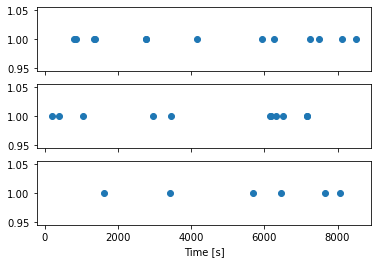

In [29]:
fig, axes = plt.subplots(nrows=len(tabwavdetect), sharex=True)
for row, ax in zip(tabwavdetect, axes):
    time = evt[np.sqrt((evt['x']-row['X'])**2 + (evt['y']-row['Y'])**2) < 18]['time']-evt['time'][0]
    ax.plot(time, np.ones(len(time)), 'o')
    
ax.set_xlabel('Time [s]')

## Spectra
### TYC itself

In [231]:
from sherpa.astro import ui

In [492]:
ui.load_pha(1, 'TYC_2597-735-1.pi')
ui.load_pha('Ha_East', 'X-East.pi')
ui.load_pha('Ha_North', 'X-North.pi')

read ARF file TYC_2597-735-1.corr.arf
read RMF file TYC_2597-735-1.rmf
read ARF (background) file TYC_2597-735-1.corr.arf
read RMF (background) file TYC_2597-735-1.rmf
read background file TYC_2597-735-1_bkg.pi
read ARF file X-East.corr.arf
read RMF file X-East.rmf
read ARF (background) file X-East.corr.arf
read RMF (background) file X-East.rmf
read background file X-East_bkg.pi
read ARF file X-North.corr.arf
read RMF file X-North.rmf
read ARF (background) file X-North.corr.arf
read RMF (background) file X-North.rmf
read background file X-North_bkg.pi


In [493]:
for i, f in enumerate(['TYC_2597-735-1.corr.arf', "X-East.corr.arf", "X-North.corr.arf"]):
    tc = Table.read(f, format='fits')
    print(i, tc[120]['PSF_FRAC'])

0 0.897614920727732
1 0.9003615721248562
2 0.8989329358184452


In [494]:
ui.set_analysis("energy")
ui.set_stat('cstat')

In [495]:
# Set dummy response, because background is dominated by cosmics and not 
# X-ray background that is effected by the ARF
bkg_rmf = ui.unpack_rmf('TYC_2597-735-1_bkg.rmf')
bkg_arf = ui.unpack_arf('TYC_2597-735-1_bkg.arf')
bkg_arf.specresp = bkg_arf.specresp*0 + 1
pbgnd = ui.const1d("pbgnd")
#gbgnd = ui.gauss1d("gbgnd")
#gbgnd.pos = 2.15
#gbgnd.fwhm = .1
#gbgnd.pos.frozen = True
#gbgnd.fwhm.frozen = True

rsp = ui.get_response(1)
bscale = ui.get_bkg_scale(1, )
smodel = ui.xsphabs.galabs * ui.xsapec.emiss

bmdl = bkg_rmf(bkg_arf(pbgnd)) # + gbgnd))
smdl = rsp(smodel) + bscale*bmdl
ui.set_full_model(1, smdl)
ui.set_bkg_full_model(1, bmdl)

pbgnd.c0.frozen = False
ui.notice()
ui.ignore(None, .4)
ui.ignore(7., None)
ui.ignore(2., 2.5)

In [496]:
#pbgnd.c0.frozen = False
#gbgnd.ampl.frozen = False
pbgnd.c0 = 1e-3  # start close to final value to speed up convergence
ui.fit_bkg(1)
#pbgnd.c0.frozen = True
#gbgnd.ampl.frozen = True

Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 959.227
Final fit statistic   = 455.727 at function evaluation 11
Data points           = 415
Degrees of freedom    = 414
Probability [Q-value] = 0.0767827
Reduced statistic     = 1.10079
Change in statistic   = 503.5
   pbgnd.c0       0.00547827   +/- 0.000344207 


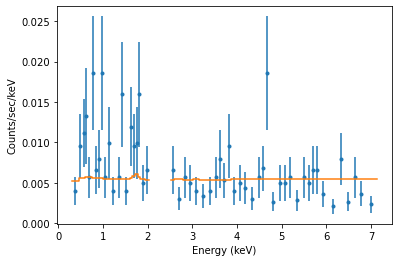

In [497]:
ui.group_counts(1, 5)
ui.plot_bkg_fit(1)
fig = plt.gcf()
ax = plt.gca()
ax.set_title('')
fig.savefig('/Users/guenther/MITDropbox/my_articles/KeriTYC/figures/bkg_spec.pdf', bbox_inches='tight')

In [498]:
ui.ungroup(1)
emiss.kT = 1
galabs.nH=1
ui.fit(1)
ui.conf(1)

Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 838.917
Final fit statistic   = 787.192 at function evaluation 45
Data points           = 1170
Degrees of freedom    = 1166
Probability [Q-value] = 1
Reduced statistic     = 0.675122
Change in statistic   = 51.7246
   galabs.nH      0.604081     +/- 0.995259    
   emiss.kT       1.08483      +/- 1.02644     
   emiss.norm     1.54077e-05  +/- 1.85867e-05 
   pbgnd.c0       0.00597057   +/- 0.000305984 
galabs.nH lower bound:	-0.481531
pbgnd.c0 lower bound:	-0.000283121
emiss.norm lower bound:	-8.51332e-06
galabs.nH upper bound:	0.453086
emiss.kT lower bound:	-0.953167
pbgnd.c0 upper bound:	0.000291482
emiss.kT upper bound:	0.460451
emiss.norm upper bound:	0.0594183
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-

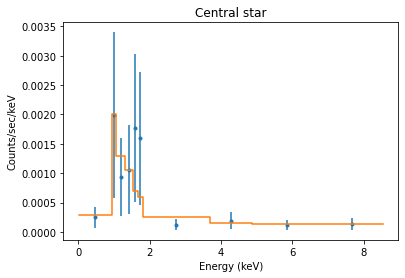

In [507]:
ui.group_counts(1, 2)
ui.plot_fit(1)
#ui.plot_model_component(1, emiss, overplot=True)

ax = plt.gca()
ax.set_title('Central star')
ax.set_label('energy [keV]')

In [500]:
ui.copy_data(1, 2)

In [501]:
smodel2 = ui.xsphabs.galabs2 * ui.xsapec.emiss2

bmdl = bkg_rmf(bkg_arf(pbgnd)) # + gbgnd))
smdl2 = rsp(smodel2) + bscale*bmdl
ui.set_full_model(2, smdl2)
ui.set_bkg_full_model(2, bmdl)

ui.notice()
ui.ignore(None, .4)
ui.ignore(7., None)
ui.ignore(2., 2.5)

ui.ungroup(2)
emiss2.kT = 1
galabs2.nH=0.017
galabs2.nH.frozen = True
ui.fit(2)
ui.conf(2)

Dataset               = 2
Method                = levmar
Statistic             = cstat
Initial fit statistic = 63.1957
Final fit statistic   = 57.9216 at function evaluation 233
Data points           = 80
Degrees of freedom    = 77
Probability [Q-value] = 0.948624
Reduced statistic     = 0.752229
Change in statistic   = 5.27407
   emiss2.kT      64           +/- 0           
   emiss2.norm    2.48132e-05  +/- 1.49056e-05 
   pbgnd.c0       0.00676277   +/- 0.00120816  
emiss2.kT lower bound:	-59.5935
emiss2.kT upper bound:	-----
emiss2.norm lower bound:	-1.54565e-05
emiss2.norm upper bound:	1.49529e-05
pbgnd.c0 lower bound:	-0.0010891
pbgnd.c0 upper bound:	0.00123185
Dataset               = 2
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   emiss2.kT             

In [508]:
def plot_faint_spec(id, id2, grpcounts=2):
    dat = ui.get_data(id)
    dat.ungroup()
    dat.group_counts(num=2, tabStops=~dat.mask)
    ui.plot_data(id, yerrorbars=True, xerrorbars=True)
    ui.notice()
    ui.ungroup(id)
    plfit = ui.get_fit_plot(id)
    plfit.modelplot.overplot()
    if id2 is not None:
        ui.ungroup(id2)
        plfit = ui.get_fit_plot(id2)
        plfit.modelplot.overplot()

    ax = plt.gca()
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.get_xaxis().set_minor_formatter(mpl.ticker.LogFormatterMathtext(labelOnlyBase=False,
                                                               minor_thresholds=(2, .5)))
    ax.tick_params(axis='x', labelsize=mpl.rcParams['xtick.labelsize'], which='both')
    ax.set_title('')
    ui.notice(.4, 5.)
    bkgpl = ui.get_bkg_plot(id)
    ax.plot(bkgpl.x, ui.get_bkg_scale(id) * bkgpl.y, 'k+')
    #ax.errorbar(bkgpl.x, ui.get_bkg_scale(1) * bkgpl.y, ui.get_bkg_scale(1) * bkgpl.xerr)
    ax.set_xlim(.4, 5.)
    ax.set_ylim(0, None)
    lines = ax.get_lines()
    #lines[0].set_linestyle('-')
    #lines[1].set_marker(None)
    if id2 is None:
        ax.legend([lines[1], lines[2], lines[-1]],['data', 'fitted model',
                                                        'scaled background'])        
    else:
        ax.legend([lines[1], lines[2], lines[4], lines[-1]],['data', 'fitted model',
                                                        'fixed column density', 'scaled background'])
        # Plot data again in correct color. Just hardcode first color in matplotlib cycle for simplicity.
        #ui.plot_data(1, overplot=True, color='#1f77b4')
    ax.axvspan(2, 2.5, facecolor='.7')
    fig = plt.gcf()
    return fig

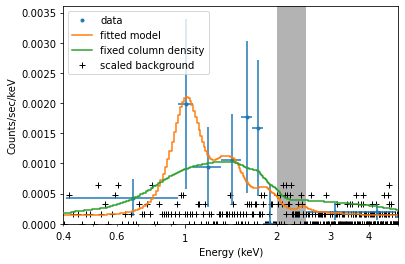

In [510]:
ui.notice()
ui.ignore(None, .4)
ui.ignore(7., None)
ui.ignore(2., 2.5)
fig = plot_faint_spec(1, 2, 2)
fig.savefig('/Users/guenther/MITDropbox/my_articles/KeriTYC/figures/TYC_spec.pdf', bbox_inches='tight')
ui.notice()
ui.ignore(None, .4)
ui.ignore(7., None)
ui.ignore(2., 2.5)

In [511]:
apecflux = ui.calc_energy_flux(lo=.5, hi=5., model=emiss)
lx = (apecflux * u.erg / u.s / u.cm**2 * (1.9e3 * u.pc)**2).to(u.erg / u.s)
apecflux, lx

(3.604892210119745e-14, <Quantity 1.23908351e+30 erg / s>)

In [554]:
apecflux2 = ui.calc_energy_flux(lo=.5, hi=5., model=emiss2)
lx2 = (apecflux2 * u.erg / u.s / u.cm**2 * (1.9e3 * u.pc)**2).to(u.erg / u.s)
apecflux2, lx2

(2.3258510757329305e-14, <Quantity 7.99447955e+29 erg / s>)

In [ ]:
ui.calc_energy_flux(lo=.5, hi=5., model=galabs*emiss)

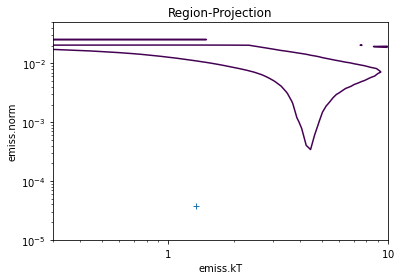

In [68]:
# This takes a while
pbgnd.c0.frozen = True
ui.reg_proj(emiss.kT, emiss.norm, id=1, min=[0.3, 1e-5], max=[10., 5e-2], nloop=[50, 50],
            sigma=[1, 5, 10.], log=(True, True))


### Combined Ha emission regions

In [469]:
rt.combine_spectra(src_spectra='Ha_East.pi,Ha_North.pi', outroot='combined', clobber=True)

Prepared to combine 2 spectra

source PHA: Ha_East.pi
       ARF: Ha_East.corr.arf
       RMF: Ha_East.rmf
    background PHA: Ha_East_bkg.pi
               ARF: Ha_East_bkg.arf
               RMF: Ha_East_bkg.rmf
source PHA: Ha_North.pi
       ARF: Ha_North.corr.arf
       RMF: Ha_North.rmf
    background PHA: Ha_North_bkg.pi
               ARF: Ha_North_bkg.arf
               RMF: Ha_North_bkg.rmf

The following files were created:
  combined_src.pi
  combined_bkg.pi
  combined_src.arf
  combined_bkg.arf
  combined_src.rmf
  combined_bkg.rmf

In [470]:
ui.load_pha('combined', 'combined_src.pi')
ui.notice()
ui.ignore(None, .4)
ui.ignore(7., None)
ui.ignore(2., 2.5)

read ARF file combined_src.arf
read RMF file combined_src.rmf
read ARF (background) file combined_bkg.arf
read RMF (background) file combined_bkg.rmf
read background file combined_bkg.pi


In [543]:
# Set dummy response, because background is dominated by cosmics and not 
# X-ray background that is effected by the ARF
bkg_rmf = ui.unpack_rmf('combined_bkg.rmf')
bkg_arf = ui.unpack_arf('combined_bkg.arf')
bkg_arf.specresp = bkg_arf.specresp*0 + 1
pbgnd = ui.const1d("pbgnd")

rsp = ui.get_response('combined')
bscale = ui.get_bkg_scale('combined', )
smodel = ui.xsphabs.galabsknot * ui.xsapec.emissknot

bmdl = bkg_rmf(bkg_arf(pbgnd))
smdl = rsp(smodel) + bscale*bmdl
ui.set_full_model('combined', smdl)
ui.set_bkg_full_model('combined', bmdl)


In [544]:
# Just to see it's reasonable
ui.fit_bkg(1)

Dataset               = 1
Method                = levmar
Statistic             = cstat
Initial fit statistic = 469.309
Final fit statistic   = 455.727 at function evaluation 11
Data points           = 415
Degrees of freedom    = 414
Probability [Q-value] = 0.0767827
Reduced statistic     = 1.10079
Change in statistic   = 13.5817
   pbgnd.c0       0.00547814   +/- 0.000344248 


In [545]:
pbgnd.c0.frozen = False

In [546]:
ui.ungroup('combined')
emissknot.kT = 1
galabsknot.nH = 1
ui.fit('combined')
ui.conf('combined')

Dataset               = combined
Method                = levmar
Statistic             = cstat
Initial fit statistic = 862647
Final fit statistic   = 1097.46 at function evaluation 96
Data points           = 830
Degrees of freedom    = 826
Probability [Q-value] = 6.09777e-10
Reduced statistic     = 1.32864
Change in statistic   = 861550
   galabsknot.nH   1.34721      +/- 0.480313    
   emissknot.kT   0.543449     +/- 0.519589    
   emissknot.norm   0.000152086  +/- 0.000304735 
   pbgnd.c0       0.00550151   +/- 0.000241421 
emissknot.kT lower bound:	-0.225281
emissknot.kT upper bound:	0.243048
pbgnd.c0 lower bound:	-0.000223684
galabsknot.nH lower bound:	-0.293531
galabsknot.nH upper bound:	0.421373
emissknot.norm lower bound:	-7.49157e-05
pbgnd.c0 upper bound:	0.000230442
emissknot.norm upper bound:	0.000512954
Dataset               = combined
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cstat
confidence 1-si

In [547]:
ui.copy_data('combined', 'combined2')
ui.notice()
ui.ignore(None, .4)
ui.ignore(7., None)
ui.ignore(2., 2.5)

smodel2 = ui.xsphabs.galabsknot2 * ui.xsapec.emissknot2

bmdl = bkg_rmf(bkg_arf(pbgnd))
smdl2 = rsp(smodel) + bscale*bmdl
ui.set_full_model('combined2', smdl2)
ui.set_bkg_full_model('combined2', bmdl)

ui.ungroup('combined2')
emissknot2.kT = 1
galabsknot2.nH=0.017
galabsknot2.nH.frozen = True
ui.fit('combined2')

Dataset               = combined2
Method                = levmar
Statistic             = cstat
Initial fit statistic = 1097.46
Final fit statistic   = 1097.46 at function evaluation 9
Data points           = 830
Degrees of freedom    = 826
Probability [Q-value] = 6.09787e-10
Reduced statistic     = 1.32864
Change in statistic   = 0.000122269
   galabsknot.nH   1.34728      +/- 0.480036    
   emissknot.kT   0.54362      +/- 0.520074    
   emissknot.norm   0.000152082  +/- 0.000304673 
   pbgnd.c0       0.00550151   +/- 0.000241421 


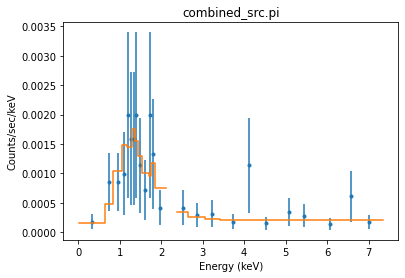

In [548]:
ui.group_counts('combined2', 2)
ui.plot_fit('combined2')
#ui.plot_model_component(1, emiss, overplot=True)
ui.notice()
ui.ignore(None, .4)
ui.ignore(7., None)
ui.ignore(2., 2.5)

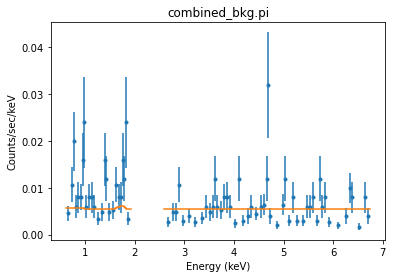

In [549]:
ui.group_counts('combined2', 5)
ui.plot_bkg_fit('combined2')

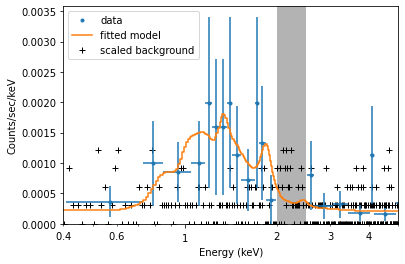

In [550]:
fig = plot_faint_spec('combined', None, grpcounts=2)
fig.savefig('/Users/guenther/MITDropbox/my_articles/KeriTYC/figures/combined.pdf', bbox_inches='tight')
ui.notice()
ui.ignore(None, .4)
ui.ignore(7., None)
ui.ignore(2., 2.5)

In [551]:
apecfluxknot = ui.calc_energy_flux(lo=.5, hi=5., model=emissknot)
lxknot = (apecfluxknot * u.erg / u.s / u.cm**2 * (1.9e3 * u.pc)**2).to(u.erg / u.s)
apecfluxknot, lxknot

(4.4054146987349827e-13, <Quantity 1.51424131e+31 erg / s>)

In [480]:
apecfluxknot = ui.calc_energy_flux(lo=.5, hi=5., model=emissknot2)
lxknot = (apecfluxknot * u.erg / u.s / u.cm**2 * (1.9e3 * u.pc)**2).to(u.erg / u.s)
apecfluxknot, lxknot

(2.0687297716723377e-14, <Quantity 7.1106951e+29 erg / s>)

In [552]:
apecfluxknot = ui.calc_energy_flux(lo=.5, hi=5., model=emissknot2)
lxknot = (apecfluxknot * u.erg / u.s / u.cm**2 * (1.9e3 * u.pc)**2).to(u.erg / u.s)
apecfluxknot, lxknot

(2.570735528943268e-09, <Quantity 8.83620315e+34 erg / s>)

In [341]:
ui.ungroup("combined")
ui.conf('combined')

galabs.nH lower bound:	-0.257055
emiss.norm lower bound:	-6.57481e-05
emiss.kT lower bound:	-0.229332
pbgnd.c0 lower bound:	-0.000224974
emiss.kT upper bound:	0.247119
galabs.nH upper bound:	0.469864
emiss.norm upper bound:	0.0005624
pbgnd.c0 upper bound:	0.000230674
Dataset               = combined
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   galabs.nH         1.30711    -0.257055     0.469864
   emiss.kT         0.543702    -0.229332     0.247119
   emiss.norm    0.000142039 -6.57481e-05    0.0005624
   pbgnd.c0       0.00550229 -0.000224974  0.000230674


### Estimate X-ray flux needed to detect large extended emission
I placed a background regions in ds9 using the upper half of the chip and then got the bkg rate in the 1-2 keV range with DAX. The exact numbers depend a little on the exact location of the region, but the background is (as it should be!) pretty uniform, so the numbers don't change significantly.

In [56]:
bkg_err_rate = 0.008 * (69/8.3)* u.count / u.s / (21856 * u.pixel**2) / (0.492 * u.arcsec / u.pixel)**2
bkg_err_rate

<Quantity 1.25707184e-05 ct / (arcsec2 s)>

In [57]:
bkg_err_flux = bkg_err_rate * (1.5 * u.keV).to(u.erg) / u.count
bkg_err_flux

<Quantity 3.02107669e-14 erg / (arcsec2 s)>

In [58]:
# correct for instrument effective area and distance
d = 1.9 * u.kpc
bkg_err_flux_at_src = (bkg_err_flux / (500 * u.cm**2) * d**2).to(u.erg/u.s/u.arcsec**2)
bkg_err_flux_at_src

<Quantity 2.07682565e+27 erg / (arcsec2 s)>

In [59]:
# convert from per arcsec sky area to a physical area at distance of TYC
(bkg_err_flux_at_src / ((1900 * u.au) / (1 * u.arcsec))**2).to(u.erg/u.s/u.pc**2)

<Quantity 2.44761498e+31 erg / (pc2 s)>

## Other calculations

In [555]:
np.log10(1.2e-3 / 12.1**2), np.log10(6e-5 / 2.9**2)

(-5.0863894945852755, -5.146644745414268)

In [556]:
# get log T
np.log10(5850)

3.7671558660821804

In [557]:
13.7/10**-0.5, 13.7/10**1

(43.32320394430679, 1.3699999999999999)

## Calculate some other numbers with units

In [558]:
10**2.07

117.48975549395291

In [559]:
# L_X / L_bol
np.log10(lx / (110 * u.L_sun))

<Quantity -5.53126404>

In [560]:
# Nature paper says "0.0008 mag scatter in B band". How much is that in linear scale?
(1.008 * u.ABmag).to(u.erg/u.s/u.cm**2/u.Hz) / (1. * u.ABmag).to(u.erg/u.s/u.cm**2/u.Hz)

<Quantity 0.99265881>

In [561]:
n=100
r=3e16
v=500

In [562]:
(r * u.cm).to(u.pc)

<Quantity 0.00972234 pc>

In [563]:
u.L_sun.to(u.erg/u.s)

3.8279999999999997e+33

In [564]:
4.1e-6 * u.L_sun * (n/100) * (r/1e16)**2 * (v/100)**5.5

<Quantity 0.25784659 solLum>

In [565]:
(4.5e-5 * u.L_sun * (n/100)**2 * (r/1e16)**3 * (v/100)**1).to(u.erg/u.s)

<Quantity 2.32551e+31 erg / s>

In [566]:
(1900 * u.au).to(u.cm)

<Quantity 2.84235954e+16 cm>

In [567]:
# Raga+ 2002 - mass flux though X-East or X-North shock
(np.pi * (1900/2 * u.au)**2 * 1e2 / u.cm**3 * 500 * u.km / u.s * 0.62 * c.m_p).to(u.M_sun/u.year)

<Quantity 5.22162216e-08 solMass / yr>

Similar calculation, but this time straight from using the fitten VEM. I expect the results to be similar to a factor of a few, which it is. And, important, this result does not depend on the density, only the total mass flux.

In [568]:
VEM = (emiss2.norm.val * 1e14 * 4 * np.pi * (1900 * u.pc)**2).to(u.cm**2) / u.cm**5
VEM

<Quantity 1.0717678e+54 1 / cm3>

In [569]:
n = 100000  / u.cm**3

In [570]:
d_cool = 20.9 * u.au * (1e5/u.cm**3 / n) # for vshock = 500, otherwise need other parameter here

A = VEM / n**2 / d_cool
dotM = (A * n * 500 * u.km / u.s * 0.62 * c.m_p).to(u.M_sun/u.year)
dotM

<Quantity 2.82089253e-08 solMass / yr>

In [571]:
# Time for material to flow through the d_cool of the shock in X-east and X-north
(2000 * u.au / (500 * u.km / u.s)).to(u.year)

<Quantity 18.96188185 yr>

In [572]:
# TYC rotational velocity on equator, assuming P = 13.8 days
vequat = (2 * np.pi * 11 * u.R_sun / (13.8 * u.day)).to(u.km/u.s)
vequat

<Quantity 40.32753975 km / s>

In [573]:
np.rad2deg(np.arcsin(6.5/40))

9.352035057563153

In [574]:
(1e31 * u.erg / u.s / u.pc**2 * (6e18 * u.cm)**2).to(u.erg/u.s)

<Quantity 3.78095415e+31 erg / s>

In [575]:
# p_rot  / tau_conf  (for table 3)
Ro = 13.7 / np.array([0.0673, 0.0503, 0.0642, 0.312, 0.877, 2.589])
Ro

array([203.56612184, 272.36580517, 213.39563863,  43.91025641,
        15.62143672,   5.29161839])

In [576]:
lx

<Quantity 1.23908351e+30 erg / s>

In [577]:
(lx / (110 * u.L_sun)).decompose() * Ro**2

<Quantity [1.21940218e-01, 2.18293662e-01, 1.34000692e-01, 5.67372011e-03,
           7.18088397e-04, 8.23973027e-05]>

In [535]:
# Estimate BP Psc radius from surface gravity and mass
import astropy.constants as c

((c.G * 1.8 * u.M_sun / (10**2.8 * u.cm/u.s**2))**0.5).decompose()

<Quantity 6.15307303e+09 m>

In [536]:
_.to(u.R_sun)

<Quantity 8.84443442 solRad>

In [537]:
(_ * 2 * np.pi / (33 * u.km/u.s)).to(u.day)

<Quantity 13.55951811 d>

## Plot for L_X

In [538]:
Wright2011 = Table.read('J_ApJ_743_48/catalog.dat', readme='J_ApJ_743_48/ReadMe', format='ascii.cds')

In [539]:
# eqn 11 in Wright+ 2011
logtau = 1.16 - 1.49 * np.log10(Wright2011['M*']) - 0.54 * np.log10(Wright2011['M*'])**2
Wright2011['tau'] = 10**logtau * u.day

In [540]:
G05tab1 = Table.read('Gondoin20052007/2005table1.tex', format='ascii.latex')
G05tab2 = Table.read('Gondoin20052007/2005table2.tex', format='ascii.latex')

# There is different LaTeX formatting in that table. It's faster to type in the values as floats by hand
G05tab1['Lx'] = np.array([0.82, 5.04, 1.95, 4.69, 9.24, 55.7, 2.41, 2.98, 3.03, 27.65, 1.073, 28.2]) * 1e30 * u.erg/u.s
# For range,s just use the middle. We are plotting in log space, so even a factor of 2 uncertainty is not much
G05tab1['Lbol'] = [86.7, 24.7, 14.9, 166, 88.7, (21+59)/2, 34.3, 149, 59.4, (17+24)/2, 35.8, (61+104)/2]
G05tab1['LxLbol'] = np.log10(G05tab1['Lx'] / (G05tab1['Lbol'] * u.L_sun))

In [541]:
G07tab1 = Table.read('Gondoin20052007/2007table1.tex', format='ascii.latex')
G07tab2 = Table.read('Gondoin20052007/2007table2.tex', format='ascii.latex')
G07tab1['Lx'] = np.array([float(d.split('$')[0]) for d in G07tab1['$L_{\\rm X}$'].data]) * 1e30 * u.erg/u.s
G07tab2['Prot'] = np.array([float(d.split('(')[0]) for d in G07tab2['$P_{\\rm rot}$'].data])
G07tab1['LxLbol'] = np.log10(G07tab1['Lx'] / (G07tab1['$L$'] * u.L_sun))

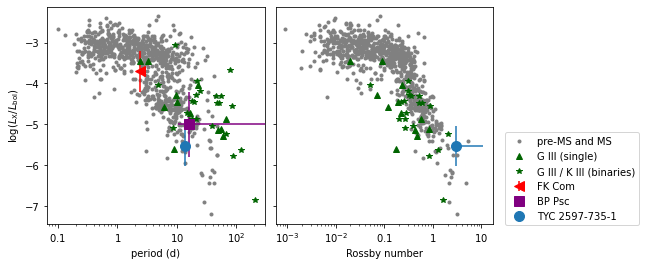

In [578]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))

outwr = axes[0].semilogx(Wright2011['Prot'], Wright2011['Lx/bol'], '.', c='.5', label='pre-MS and MS', zorder=-10)
axes[1].semilogx(Wright2011['Prot'] / Wright2011['tau'], Wright2011['Lx/bol'], '.', c='.5')

axes[0].semilogx(G05tab2['$P$'], G05tab1['LxLbol'], '^', c='darkgreen',
                 label='G III (single)')
axes[1].semilogx(G05tab2['$R_{\\rm o}$'], G05tab1['LxLbol'], '^', c='darkgreen')


axes[0].semilogx(G07tab2['Prot'], G07tab1['LxLbol'], '*', c='darkgreen',
                 label='G III / K III (binaries)')
axes[1].semilogx(G07tab2['$R_{\\rm o}$'], G07tab1['LxLbol'], '*', c='darkgreen')


## FK Com
# 2016ApJS..223....5A Lx/Lbol = 2e-4  
# 1993A&A...278..449J  P=2.4 days
outfk = axes[0].errorbar(2.4, np.log10(2e-4), yerr=.5, fmt='<', c='r', label='FK Com', ms=10)

## BP Psc
# 2010ApJ...719L..65K log Lx/Lbol = -5.8 to -4.2
# highly absorbed, so period not known
# GAIA distance now proves it's a ~300 pc G giant, not a pre-MS: 
# Parallaxes (mas): 	2.7874 [0.3905] A 2018yCat.1345....0G
# Spectral type: 	G9IIIe C 2006A&A...460..695T 
# 2008ApJ...683.1085Z: 1.8 Msun, if it's a giant at 300 pc (which it is, see GAIA)
# same: log g - 2.5 +/- 0.3
# same: v sin i = 38 km/s
R_BPPsc = ((c.G * 1.8 * u.M_sun / (10**2.5 * u.cm/u.s**2))**0.5).to(u.R_sun)
Prot_bppsc = (2 * np.pi * R_BPPsc / (38 * u.km/u.s / np.sin(75 * u.degree))).to(u.day)
outbp = axes[0].errorbar(Prot_bppsc.value, -5, yerr=.8, xerr=np.array([[5.5, 400]]).T,
                         fmt='s', c='purple', label='BP Psc', ms=10)

#axes[0].errorbar(14/24, -3, yerr=.2, marker='$H$', c='gold', label='HFG 1', ms=10)
#axes[0].errorbar(8.5/24, -2, yerr=.3, marker='$D$', c='gold', label='DS 1', ms=10)
#axes[0].errorbar(5.9, -5, yerr=.3, marker='$L$', c='gold', label='LoTr 5', ms=10)
axes[0].set_xlim(None, 300)

## TYC
TYClxlbol = (lx / (110 * u.L_sun)).decompose()
outty = axes[0].errorbar(13.8, np.log10(TYClxlbol), yerr=.5, fmt='o', label='TYC 2597-735-1', ms=10)
# xerr is simple the range 2000-5000 years in the table with MESA models
axes[1].errorbar(3, np.log10(TYClxlbol), yerr=.5, xerr=np.array([[0, 8]]).T, fmt='o', ms=10)


fig.legend(bbox_to_anchor=(.92,.12), loc=(0, 0))  # Move legend to right plot
axes[0].set_xlabel('period (d)')
axes[1].set_xlabel('Rossby number')
axes[0].set_ylabel('$\log(L_\mathrm{X}/L_\mathrm{bol})$')
fig.subplots_adjust(wspace=.05)
fig.savefig('/Users/guenther/MITDropbox/my_articles/KeriTYC/figures/lxlbol.pdf', bbox_inches='tight')

## Look at TESS data

In [12]:
import lightkurve as lk

In [15]:
#search_result = lk.search_targetpixelfile('BP Psc', exptime=1800)
search_result = lk.search_targetpixelfile('TYC 2597-735-1')
search_result

SearchResult containing 0 data products.

In [82]:
tpf = search_result.download()

/Users/hamogu/anaconda3/envs/ciao/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,


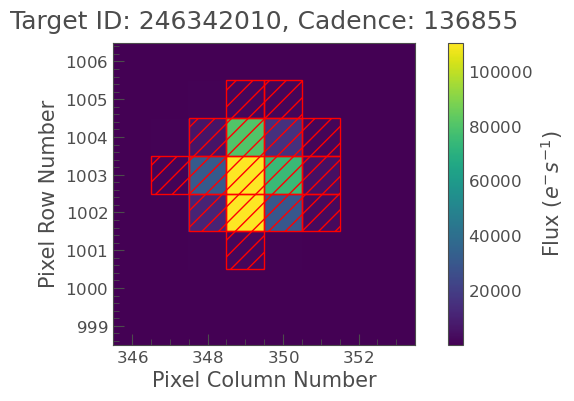

In [102]:
srcaperture = tpf.flux[0].value > 1000
srcnpix = len(np.where(aperture == True)[0])
tpf.plot(aperture_mask=srcaperture);

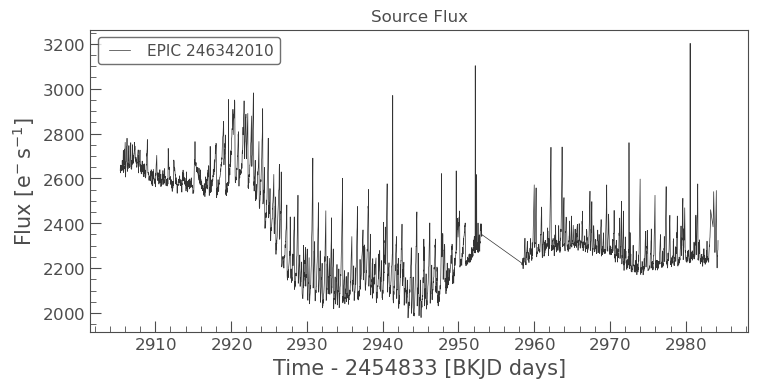

In [104]:
lc = tpf.to_lightcurve(aperture_mask=aperture)

ax = lc.remove_outliers().plot()
ax.set_title('Source Flux');

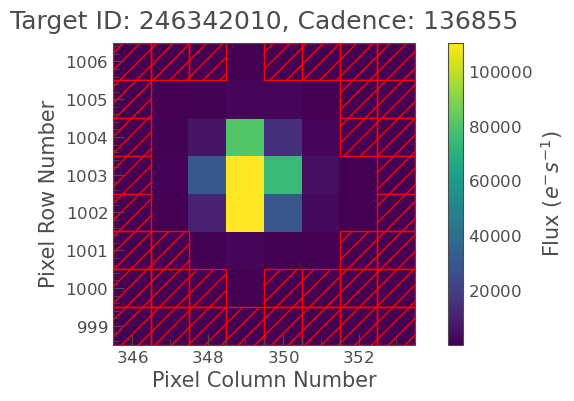

In [99]:
aperture = tpf.flux[0].value < 200
npix = len(np.where(aperture == True)[0])
tpf.plot(aperture_mask=aperture);

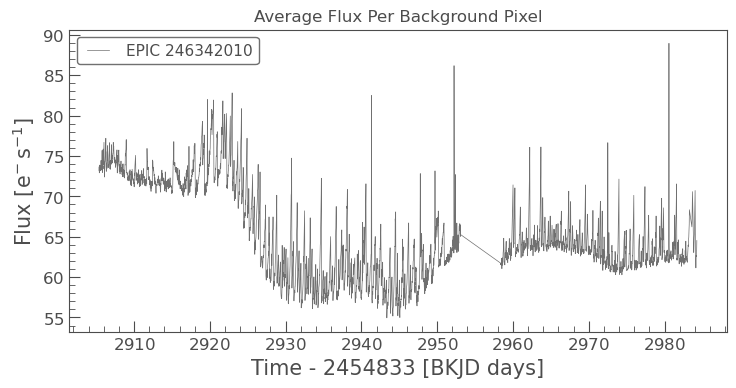

In [100]:
bkg_lc = tpf.to_lightcurve(aperture_mask=aperture)
bkg_lc /= npix  # Convert to electrons per second per pixel

ax = bkg_lc.remove_outliers().plot(normalize=False, alpha=0.7)
ax.set_title('Average Flux Per Background Pixel');

Looks like all noise - the same patter is in the background. So, I cannot use that to estimate the rotation period.

## Predictions for other stars

In [302]:
TYC4144 = 42 * c.L_sun / (4 * np.pi * (395 * u.pc)**2) * 1e-5

In [303]:
TYC4144.to(u.erg/u.s/u.cm**2)

<Quantity 8.61223901e-14 erg / (cm2 s)>

In [304]:
(100 * c.L_sun / (4 * np.pi * (880 * u.pc)**2) * 1e-5).to(u.erg/u.s/u.cm**2)

<Quantity 4.13138464e-14 erg / (cm2 s)>

In [38]:
10**(7.93-12)/2

4.25569019101188e-05

## Simulations for follow-up XMM proposal

In [193]:
galabs*emiss

<BinaryOpModel model instance '(xsphabs.galabs * xsapec.emiss)'>

In [194]:
galabs2 * emiss2

<BinaryOpModel model instance '(xsphabs.galabs2 * xsapec.emiss2)'>

In [117]:
ui.set_source('xmm_TYC4', galabs * emiss)
ui.fake_pha('xmm_TYC4', 'XMMproposal/pn-med-5.arf.gz', 'XMMproposal/pn-med-5.rmf.gz', 100e3)

ui.set_source('xmm_TYC5', galabs2 * emiss2)
ui.fake_pha('xmm_TYC5', 'XMMproposal/pn-med-5.arf.gz', 'XMMproposal/pn-med-5.rmf.gz', 100e3)

In [145]:
emiss1b = ui.xsapec(name='1b')
emiss1b.kT=2.5
emiss1b.norm = emiss.norm / 4
ui.set_source('xmm_TYC4b', galabs * (emiss + emiss1b))
ui.fake_pha('xmm_TYC4b', 'XMMproposal/pn-med-5.arf.gz', 'XMMproposal/pn-med-5.rmf.gz', 100e3)

In [146]:
galabs * (emiss + emiss1b)

<BinaryOpModel model instance '(xsphabs.galabs * (xsapec.emiss + xsapec.1b))'>

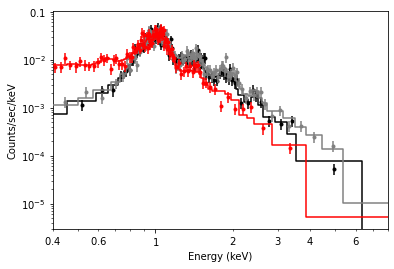

In [149]:
ui.group_counts('xmm_TYC4', 15)
ui.plot_fit('xmm_TYC4', color='k')

ui.group_counts('xmm_TYC4b', 15)
ui.plot_fit('xmm_TYC4b', overplot=True, color='.5')

ui.group_counts('xmm_TYC5', 15)
ui.plot_fit('xmm_TYC5', overplot = True, color='r')

ui.notice(None, None)
if True:
    ax = plt.gca()
    ax.set_xscale("log")
    ax.set_yscale("log")
    #ax.set_yscale("log")
    ax.get_xaxis().set_minor_formatter(mpl.ticker.LogFormatterMathtext(labelOnlyBase=False,
                                                               minor_thresholds=(2, .5)))
    ax.tick_params(axis='x', labelsize=mpl.rcParams['xtick.labelsize'], which='both')
    ax.set_title('')
    ax.set_xlim(.4, 8.)
    ax.set_ylim(3e-6, None)
    fig = plt.gcf()
    #fig.savefig('/Users/hamogu/MITDropbox/my_proposals/Co-I/XMM_TYC_simulated.pdf')

Note that the next two cells change the value of the models from the values fit to the real Chandra data to the value fit to the simulated XMM data. The nmbers will be close, but not identical, so make sure to not re-use those models for anything imporant after running these steps!

In [127]:
ui.fit('xmm_TYC4')
ui.conf('xmm_TYC4')

Dataset               = xmm_TYC4
Method                = levmar
Statistic             = cstat
Initial fit statistic = 95.2082
Final fit statistic   = 92.4982 at function evaluation 21
Data points           = 95
Degrees of freedom    = 92
Probability [Q-value] = 0.465809
Reduced statistic     = 1.00541
Change in statistic   = 2.71004
   galabs.nH      0.598997     +/- 0.0414686   
   emiss.kT       1.10311      +/- 0.0396996   
   emiss.norm     4.23132e-05  +/- 2.54296e-06 
galabs.nH lower bound:	-0.0427408
galabs.nH upper bound:	0.0522252
emiss.kT lower bound:	-0.0401788
emiss.norm lower bound:	-2.50841e-06
emiss.kT upper bound:	0.0409062
emiss.norm upper bound:	3.70401e-06
Dataset               = xmm_TYC4
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   galabs.

In [129]:
galabs2.nH.frozen = False
ui.fit('xmm_TYC5')
ui.conf('xmm_TYC5')

Dataset               = xmm_TYC5
Method                = levmar
Statistic             = cstat
Initial fit statistic = 100.761
Final fit statistic   = 100.738 at function evaluation 13
Data points           = 105
Degrees of freedom    = 102
Probability [Q-value] = 0.516745
Reduced statistic     = 0.987626
Change in statistic   = 0.0226435
   galabs2.nH     0.0174664    +/- 0.00302464  
   emiss2.kT      1.28158      +/- 0.0153753   
   emiss2.norm    1.36012e-05  +/- 4.96528e-07 
emiss2.kT lower bound:	-0.0156987
emiss2.norm lower bound:	-4.91102e-07
emiss2.kT upper bound:	0.0148997
galabs2.nH lower bound:	-0.00297258
galabs2.nH upper bound:	0.00326497
emiss2.norm upper bound:	5.06693e-07
Dataset               = xmm_TYC5
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = cstat
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  ---------

In [115]:
np.sum(ui.get_data('xmm_TYC4').counts)

1865.0

In [8]:
ui.load_pha('TYCshock', 'TYC_2597_735_1.pi')
ui.set_source('TYCshock', ui.xsphabs.absshock * ui.xsapec.ashock)
ashock.kT = 0.5
ashock.kT.frozen = True

read ARF file TYC_2597_735_1.corr.arf
read RMF file TYC_2597_735_1.rmf
read ARF (background) file TYC_2597_735_1_bkg.arf
read RMF (background) file TYC_2597_735_1_bkg.rmf
read background file TYC_2597_735_1_bkg.pi


In [9]:
ui.fit('TYCshock')

Dataset               = TYCshock
Method                = levmar
Statistic             = cstat
Initial fit statistic = 128496
Final fit statistic   = 730.12 at function evaluation 148
Data points           = 1024
Degrees of freedom    = 1022
Probability [Q-value] = 1
Reduced statistic     = 0.714403
Change in statistic   = 127766
   absshock.nH    40.8186      +/- 7.29856     
   ashock.norm    1.95366      +/- 1.22113     


In [40]:
ui.load_pha('XMMproposal/tgcat/obs_13251_tgid_4436/pha2.gz')
ui.load_arf(9, 'XMMproposal/tgcat/obs_13251_tgid_4436/meg_-1.arf.gz')
ui.load_rmf(9, 'XMMproposal/tgcat/obs_13251_tgid_4436/meg_-1.rmf.gz')
ui.load_arf(10, 'XMMproposal/tgcat/obs_13251_tgid_4436/meg_1.arf.gz')
ui.load_rmf(10, 'XMMproposal/tgcat/obs_13251_tgid_4436/meg_1.rmf.gz')

statistical errors were found in file 'XMMproposal/tgcat/obs_13251_tgid_4436/pha2.gz' 
but not used; to use them, re-read with use_errors=True
read background_up into a dataset from file XMMproposal/tgcat/obs_13251_tgid_4436/pha2.gz
read background_down into a dataset from file XMMproposal/tgcat/obs_13251_tgid_4436/pha2.gz
Multiple data sets have been input: 1-12


In [43]:
ui.set_source(9, ui.xsapec.fk1 + ui.xsapec.fk2)
ui.set_source(10, fk1 + fk2)
ui.group_counts(9, 5)
ui.group_counts(10, 5)
ui.ignore()
ui.notice(.4, 6.)
fk1.kT.frozen = False
fk2.kT.frozen = False
fk2.norm.link = None
ui.fit(9, 10)

Datasets              = 9, 10
Method                = levmar
Statistic             = cstat
Initial fit statistic = 1125.76
Final fit statistic   = 1125.76 at function evaluation 6
Data points           = 902
Degrees of freedom    = 898
Probability [Q-value] = 2.97861e-07
Reduced statistic     = 1.25363
Change in statistic   = 4.00506e-07
   fk1.kT         0.917802     +/- 0.023286    
   fk1.norm       0.000219941  +/- 1.55053e-05 
   fk2.kT         5.13952      +/- 0.200489    
   fk2.norm       0.00200702   +/- 4.06019e-05 


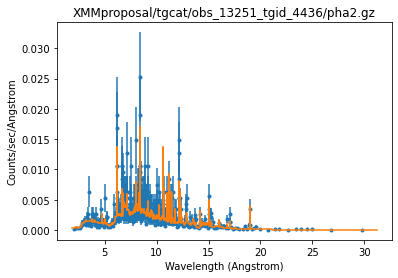

In [44]:
ui.set_analysis('wave')
ui.plot_fit(9)
ui.set_analysis('energy')

In [45]:
fk1.kT.frozen = True
fk2.kT.frozen = True
fk2.norm = fk1.norm * fk2.norm.val / fk1.norm.val

In [46]:
ui.load_pha('TYCFK', 'TYC_2597_735_1.pi')
ui.set_source('TYCFK', ui.xsphabs.tycfkabs * (fk1 + fk2))
ui.fit('TYCFK')

read ARF file TYC_2597_735_1.corr.arf
read RMF file TYC_2597_735_1.rmf
read ARF (background) file TYC_2597_735_1_bkg.arf
read RMF (background) file TYC_2597_735_1_bkg.rmf
read background file TYC_2597_735_1_bkg.pi
Dataset               = TYCFK
Method                = levmar
Statistic             = cstat
Initial fit statistic = 1179.93
Final fit statistic   = 562.705 at function evaluation 32
Data points           = 1024
Degrees of freedom    = 1022
Probability [Q-value] = 1
Reduced statistic     = 0.550592
Change in statistic   = 617.225
   tycfkabs.nH    0.678495     +/- 0.287955    
   fk1.norm       1.37599e-05  +/- 4.69835e-06 


In [82]:
ls XMMproposal/

pn-med-5.arf.gz  pn-med-5.rmf.gz  shocks.fits      tgcat/


In [119]:
ui.set_source('xmm_TYC1', absshock * ashock)
ui.fake_pha('xmm_TYC1', 'XMMproposal/pn-med-5.arf.gz', 'XMMproposal/pn-med-5.rmf.gz', 100e3)

ui.set_source('xmm_TYC2', tycfkabs * (fk1 + fk2))
ui.fake_pha('xmm_TYC2', 'XMMproposal/pn-med-5.arf.gz', 'XMMproposal/pn-med-5.rmf.gz', 100e3)

In [84]:
ui.get_rmf('xmm_TYC1')

<DataRMF data set instance 'XMMproposal/pn-med-5.rmf.gz'>

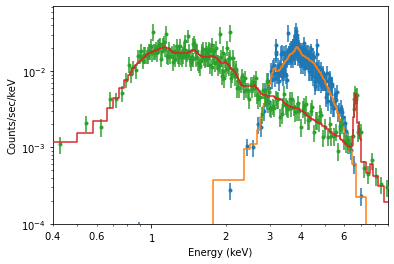

In [122]:
ui.group_counts('xmm_TYC1', 15)
ui.plot_fit('xmm_TYC1')

ui.group_counts('xmm_TYC2', 15)
ui.plot_fit('xmm_TYC2', overplot = True)

ui.notice(None, None)
if True:
    ax = plt.gca()
    ax.set_xscale("log")
    ax.set_yscale("log")
    #ax.set_yscale("log")
    ax.get_xaxis().set_minor_formatter(mpl.ticker.LogFormatterMathtext(labelOnlyBase=False,
                                                               minor_thresholds=(2, .5)))
    ax.tick_params(axis='x', labelsize=mpl.rcParams['xtick.labelsize'], which='both')
    ax.set_title('')
    ax.set_xlim(.4, 9.)
    ax.set_ylim(1e-4, None)


In [59]:
dat = ui.get_data('xmm_TYC2')

In [60]:
np.sum(dat.counts)

3859.0

In [171]:
ui.set_source('xmm_TYCresolved', galabs * emiss)
ui.fake_pha('xmm_TYCresolved', 'XMMproposal/pn-med-5.arf.gz', 'XMMproposal/pn-med-5.rmf.gz', 100e3)
dat = ui.get_data('xmm_TYCresolved')
np.sum(dat.counts)

1008.0